
# Segmentação de Áreas Inundadas com U-Net e ResNet50

Este notebook implementa um modelo de segmentação semântica para identificar áreas inundadas em imagens. Ele utiliza:
- **Arquitetura U-Net** com codificador ResNet50 pré-treinado.
- **Transferência de aprendizado** para otimizar o treinamento em datasets menores.
- **Focal Loss** para lidar com desbalanceamento de classes.

O pipeline cobre:
- Preparação dos dados
- Construção do modelo
- Treinamento inicial (transferência de aprendizado)
- Planejamento para análise de resultados


In [1]:
#Baixando Dataset Area Inundada
!kaggle datasets download faizalkarim/flood-area-segmentation


Dataset URL: https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation
License(s): CC0-1.0
 89% 95.0M/107M [00:01<00:00, 92.3MB/s]
100% 107M/107M [00:01<00:00, 102MB/s]  


In [2]:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile

# Descompacta os arquivos do dataset
with zipfile.ZipFile("flood-area-segmentation.zip", 'r') as zip_ref:
    zip_ref.extractall("flood-area-segmentation")

# Configurações iniciais de imagem e diretórios
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
DATASET_DIR = "flood-area-segmentation"
IMAGE_DIR = os.path.join(DATASET_DIR, "Image")
MASK_DIR = os.path.join(DATASET_DIR, "Mask")

# Função para carregar imagens e máscaras de segmentação
def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []
    for img_filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_filename)
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img = img_to_array(img) / 255.0  # Normalização
        images.append(img)

        mask_filename = img_filename.replace(".jpg", ".png")
        mask_path = os.path.join(mask_dir, mask_filename)
        mask = load_img(mask_path, color_mode="grayscale", target_size=(IMG_HEIGHT, IMG_WIDTH))
        mask = img_to_array(mask)
        if np.max(mask) > 1:
            mask = mask / 255.0
        mask = (mask > 0.5).astype(np.float32)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Carrega imagens e máscaras
images, masks = load_images_and_masks(IMAGE_DIR, MASK_DIR)

# Divide o dataset em treino e validação
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [3]:

# Definição do modelo U-Net com codificador ResNet50
def unet_with_resnet50_encoder():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    inputs = base_model.input

    s1 = base_model.get_layer("conv1_relu").output
    s2 = base_model.get_layer("conv2_block3_out").output
    s3 = base_model.get_layer("conv3_block4_out").output
    s4 = base_model.get_layer("conv4_block6_out").output
    b1 = base_model.get_layer("conv5_block3_out").output

    d1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    d1 = Concatenate()([d1, s4])
    d1 = Conv2D(256, (3, 3), padding="same", activation="relu")(d1)

    d2 = UpSampling2D((2, 2), interpolation="bilinear")(d1)
    d2 = Concatenate()([d2, s3])
    d2 = Conv2D(128, (3, 3), padding="same", activation="relu")(d2)

    d3 = UpSampling2D((2, 2), interpolation="bilinear")(d2)
    d3 = Concatenate()([d3, s2])
    d3 = Conv2D(64, (3, 3), padding="same", activation="relu")(d3)

    d4 = UpSampling2D((2, 2), interpolation="bilinear")(d3)
    d4 = Concatenate()([d4, s1])
    d4 = Conv2D(32, (3, 3), padding="same", activation="relu")(d4)

    d5 = UpSampling2D((2, 2), interpolation="bilinear")(d4)
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d5)

    model = Model(inputs, outputs)
    return model

# Cria o modelo U-Net
model = unet_with_resnet50_encoder()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:

# Configuração de aumento de dados
data_gen_args = dict(horizontal_flip=True, vertical_flip=True, rotation_range=90,
                     width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

train_image_gen = image_datagen.flow(X_train, batch_size=BATCH_SIZE, seed=42)
train_mask_gen = mask_datagen.flow(y_train, batch_size=BATCH_SIZE, seed=42)
val_image_gen = ImageDataGenerator().flow(X_val, batch_size=BATCH_SIZE, seed=42)
val_mask_gen = ImageDataGenerator().flow(y_val, batch_size=BATCH_SIZE, seed=42)

# Gerador combinado
def train_generator(image_gen, mask_gen):
    while True:
        img_batch = next(image_gen)
        mask_batch = next(mask_gen)
        yield img_batch, mask_batch

train_gen = train_generator(train_image_gen, train_mask_gen)
val_gen = train_generator(val_image_gen, val_mask_gen)

# Congela as camadas do ResNet50
for layer in model.layers:
    if 'resnet' in layer.name:
        layer.trainable = False

# Define a Focal Loss
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-bce)
        return alpha * (1 - pt)**gamma * bce
    return loss

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=focal_loss(alpha=0.25, gamma=2.0),
              metrics=['accuracy', MeanIoU(num_classes=2)])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_transfer_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

# Treinamento inicial
history_transfer = model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(X_val) // BATCH_SIZE,
    epochs=10,
    callbacks=[checkpoint_callback]
)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.5805 - loss: 0.1198 - mean_io_u: 0.3042
Epoch 1: val_loss improved from inf to 0.06220, saving model to best_transfer_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5863 - loss: 0.1168 - mean_io_u: 0.3042 - val_accuracy: 0.3670 - val_loss: 0.0622 - val_mean_io_u: 0.3216
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.7652 - loss: 0.0310 - mean_io_u: 0.2983
Epoch 2: val_loss did not improve from 0.06220
14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 865ms/step - accuracy: 0.7669 - loss: 0.0308 - mean_io_u: 0.2986 - val_accuracy: 0.3782 - val_loss: 0.0850 - val_mean_io_u: 0.3132
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8390 - loss: 0.0227 - mean_io_u: 0.3006
Epoch 3: val_loss did not improve from 0.06220
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 324ms/step - accuracy: 0.8387 - loss: 0.0228 - mean_io_u: 0.3005 - val_accuracy: 0.3974 - val_loss: 0.0878 - val_mean_io_u: 0.3033
Epoch 4/10
14/14

In [7]:
# Carrega os pesos do melhor modelo obtido durante a fase de transferência de aprendizado.
model.load_weights("best_transfer_model.keras")

# Desbloqueia as camadas da ResNet para permitir o ajuste fino (fine-tuning) após o aprendizado transferido.
for layer in model.layers:
    if 'resnet' in layer.name:
        layer.trainable = True

# Compila o modelo para o ajuste fino, utilizando um otimizador Adam com uma taxa de aprendizado reduzida.
# Define a função de perda como 'binary_crossentropy' para tarefas binárias e adiciona métricas de avaliação (accuracy e Mean IoU).
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=2)])

# Define os callbacks para controlar o treinamento:
callbacks = [
    # EarlyStopping interrompe o treinamento se o desempenho no conjunto de validação não melhorar por 5 épocas consecutivas.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),

    # ReduceLROnPlateau reduz a taxa de aprendizado pela metade se o desempenho no conjunto de validação não melhorar por 3 épocas consecutivas.
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),

    # ModelCheckpoint salva o modelo com melhor desempenho no conjunto de validação durante o treinamento.
    tf.keras.callbacks.ModelCheckpoint(
        "best_fine_tune_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
]

# Inicia o treinamento do modelo com ajuste fino (fine-tuning).
history_fine_tune = model.fit(
    train_gen,  # Gerador de dados para o conjunto de treinamento.
    steps_per_epoch=len(X_train) // BATCH_SIZE,  # Número de lotes por época para o conjunto de treinamento.
    validation_data=val_gen,  # Gerador de dados para o conjunto de validação.
    validation_steps=len(X_val) // BATCH_SIZE,  # Número de lotes por época para o conjunto de validação.
    epochs=20,  # Número total de épocas (treinamento continuará do ponto inicial definido).
    initial_epoch=10,  # Começa do final da transferência de aprendizado (época 10).
    callbacks=callbacks  # Usa os callbacks definidos acima.
)

Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8488 - loss: 0.4255 - mean_io_u_1: 0.3184
Epoch 11: val_loss improved from inf to 0.72627, saving model to best_fine_tune_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.8485 - loss: 0.4247 - mean_io_u_1: 0.3175 - val_accuracy: 0.4862 - val_loss: 0.7263 - val_mean_io_u_1: 0.3075 - learning_rate: 1.0000e-05
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8388 - loss: 0.3901 - mean_io_u_1: 0.3064
Epoch 12: val_loss did not improve from 0.72627
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.8395 - loss: 0.3886 - mean_io_u_1: 0.3067 - val_accuracy: 0.4019 - val_loss: 0.8731 - val_mean_io_u_1: 0.3152 - learning_rate: 1.0000e-05
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8029 - loss: 0.4369 - mean_io_u_1: 0.3062
Epoch 13: val_loss did not improve from 0.72627
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.8047 - loss: 0.4334 - mean_io_u_1: 0.3056 - val_a

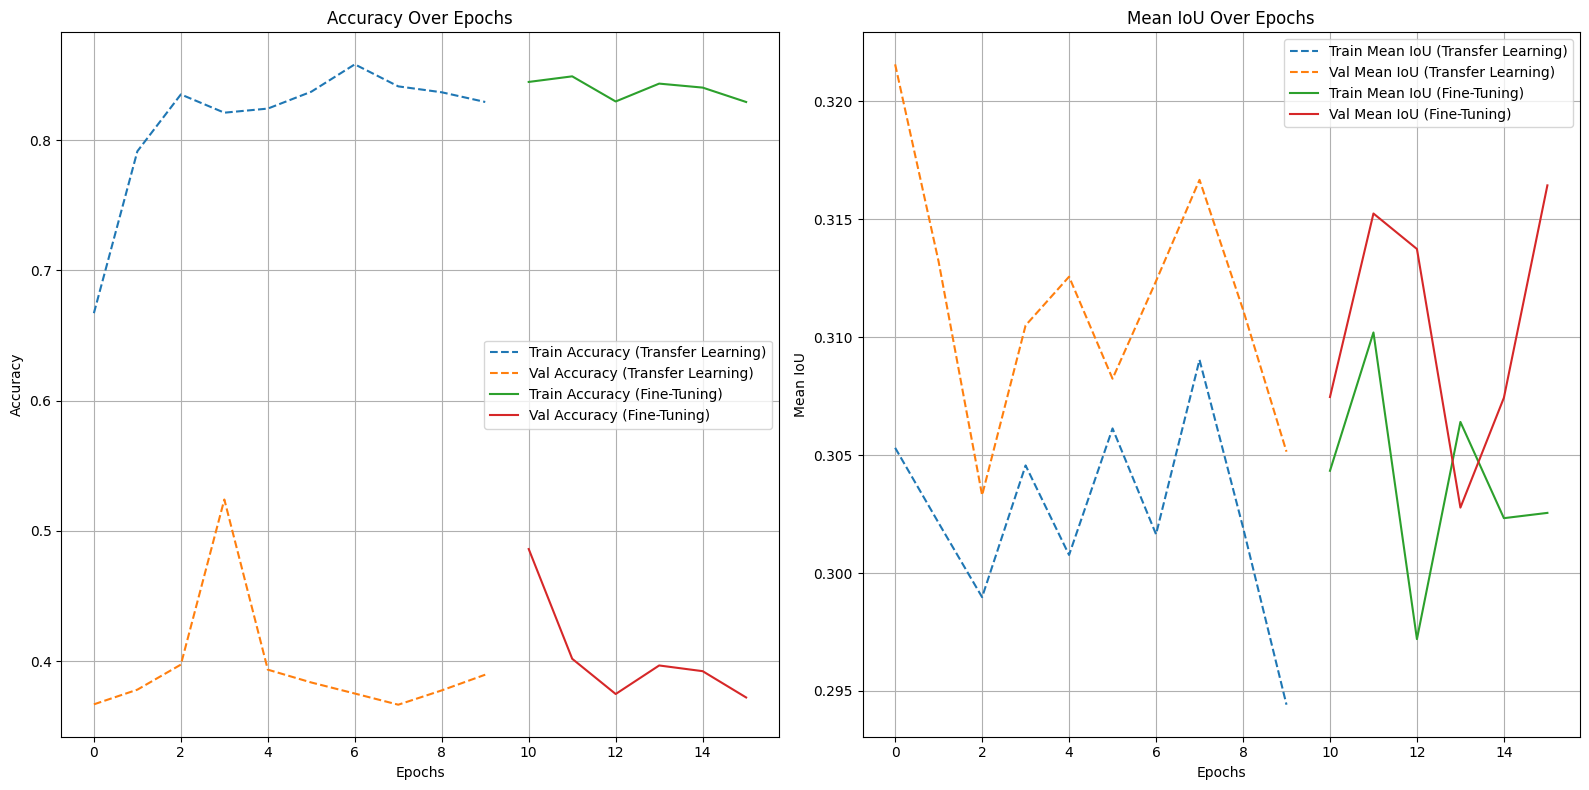

In [8]:
# Função para combinar os históricos do treinamento de transferência de aprendizado e ajuste fino.
def combine_histories(history_transfer, history_fine_tune):
    combined = {}  # Dicionário para armazenar os históricos combinados.
    for key in history_transfer.history.keys():
        # Ajusta a métrica MeanIoU caso tenha nomes diferentes nos dois históricos.
        if key == 'mean_io_u':
            combined[key] = history_transfer.history[key] + history_fine_tune.history.get('mean_io_u_1', [])
        elif key == 'val_mean_io_u':
            combined[key] = history_transfer.history[key] + history_fine_tune.history.get('val_mean_io_u_1', [])
        else:
            # Combina as métricas de outras chaves normalmente.
            combined[key] = history_transfer.history[key] + history_fine_tune.history.get(key, [])
    return combined

# Combina os históricos de transferência de aprendizado e ajuste fino.
full_history = combine_histories(history_transfer, history_fine_tune)

# Extrai as métricas de precisão (accuracy) e IoU do histórico combinado.
train_accuracy = full_history['accuracy']
val_accuracy = full_history['val_accuracy']
train_mean_iou = full_history['mean_io_u']
val_mean_iou = full_history['val_mean_io_u']

# Calcula os números de épocas para transferência de aprendizado e ajuste fino.
epochs_transfer = len(history_transfer.history['accuracy'])
epochs_fine_tuning = len(history_fine_tune.history['accuracy'])
total_epochs = epochs_transfer + epochs_fine_tuning

# Cria os intervalos de épocas para cada fase do treinamento.
transfer_epochs = range(epochs_transfer)
fine_tuning_epochs = range(epochs_transfer, total_epochs)

# Configuração da visualização dos gráficos
plt.figure(figsize=(16, 8))  # Tamanho da figura.

# Gráfico de precisão (accuracy) ao longo das épocas.
plt.subplot(1, 2, 1)
plt.plot(transfer_epochs, train_accuracy[:epochs_transfer], label='Train Accuracy (Transfer Learning)', linestyle='--')
plt.plot(transfer_epochs, val_accuracy[:epochs_transfer], label='Val Accuracy (Transfer Learning)', linestyle='--')
plt.plot(fine_tuning_epochs, train_accuracy[epochs_transfer:], label='Train Accuracy (Fine-Tuning)')
plt.plot(fine_tuning_epochs, val_accuracy[epochs_transfer:], label='Val Accuracy (Fine-Tuning)')
plt.title('Accuracy Over Epochs')  # Título do gráfico.
plt.xlabel('Epochs')  # Rótulo do eixo X.
plt.ylabel('Accuracy')  # Rótulo do eixo Y.
plt.legend()  # Mostra a legenda.
plt.grid(True)  # Adiciona uma grade.

# Gráfico de IoU (Mean IoU) ao longo das épocas.
plt.subplot(1, 2, 2)
plt.plot(transfer_epochs, train_mean_iou[:epochs_transfer], label='Train Mean IoU (Transfer Learning)', linestyle='--')
plt.plot(transfer_epochs, val_mean_iou[:epochs_transfer], label='Val Mean IoU (Transfer Learning)', linestyle='--')
plt.plot(fine_tuning_epochs, train_mean_iou[epochs_transfer:], label='Train Mean IoU (Fine-Tuning)')
plt.plot(fine_tuning_epochs, val_mean_iou[epochs_transfer:], label='Val Mean IoU (Fine-Tuning)')
plt.title('Mean IoU Over Epochs')  # Título do gráfico.
plt.xlabel('Epochs')  # Rótulo do eixo X.
plt.ylabel('Mean IoU')  # Rótulo do eixo Y.
plt.legend()  # Mostra a legenda.
plt.grid(True)  # Adiciona uma grade.

# Ajusta o layout para evitar sobreposição de elementos e exibe os gráficos.
plt.tight_layout()
plt.show()